In [89]:
#Hydraulic system condition monitoring
#Task: forecast failure.
import pandas as pd
from scipy.signal import decimate
import matplotlib.pyplot as plt
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [105]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix

### Loading the data

In [4]:
features = ['Cooler Cond.','Valve Cond.', 'pump leakage','Hydraulic accm.','stable flag']
target = pd.read_csv("e:/data/Hydraulic_Systems/profile.txt",sep='\t', names = features)
target.columns = features
target.shape

(2205, 5)

In [34]:
target.tail()

,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0
2204,100,100,0,90,0


In [5]:
#There are 2205 states from each of the 5 target condition variables.
target.isnull().sum()

Cooler Cond.       0
Valve Cond.        0
pump leakage       0
Hydraulic accm.    0
stable flag        0
dtype: int64

In [6]:
#Pressure sensors fs = 100 Hz
PS1 = pd.read_csv("e:/data/Hydraulic_Systems/ps1.txt",sep='\t',header=None)
PS2 = pd.read_csv("e:/data/Hydraulic_Systems/ps2.txt",sep='\t',header=None)
PS3 = pd.read_csv("e:/data/Hydraulic_Systems/ps3.txt",sep='\t',header=None)
PS4 = pd.read_csv("e:/data/Hydraulic_Systems/ps4.txt",sep='\t',header=None)
PS5 = pd.read_csv("e:/data/Hydraulic_Systems/ps5.txt",sep='\t',header=None)
PS6 = pd.read_csv("e:/data/Hydraulic_Systems/ps6.txt",sep='\t',header=None)

In [10]:
#Each pressure sensors has 6k features and 2205 measurements. 
print('Pressure sensors shape')
print('PS1: {}'.format(PS1.shape))
print('PS2: {}'.format(PS2.shape))
print('PS3: {}'.format(PS3.shape))
print('PS4: {}'.format(PS4.shape))
print('PS5: {}'.format(PS5.shape))
print('PS6: {}'.format(PS6.shape))

Pressure sensors shape
PS1: (2205, 6000)
PS2: (2205, 6000)
PS3: (2205, 6000)
PS4: (2205, 6000)
PS5: (2205, 6000)
PS6: (2205, 6000)


In [11]:
#Motor power sensor fs = 100 Hz
EPS1= pd.read_csv("e:/data/Hydraulic_Systems/EPS1.txt",sep='\t',header=None)

In [12]:
print('EPS1 shape: {}'.format(EPS1.shape))

EPS1 shape: (2205, 6000)


In [13]:
#Volume flow sensors fs = 10 Hz
FS1 = pd.read_csv("e:/data/Hydraulic_Systems/FS1.txt",sep='\t',header=None)
FS2 = pd.read_csv("e:/data/Hydraulic_Systems/FS2.txt",sep='\t',header=None)

In [14]:
print('FS1 shape: {}'.format(FS1.shape))
print('FS2 shape: {}'.format(FS2.shape))

FS1 shape: (2205, 600)
FS2 shape: (2205, 600)


In [15]:
#Temperature sensors fs= 1 Hz
TS1 = pd.read_csv("e:/data/Hydraulic_Systems/TS1.txt",sep='\t',header=None)
TS2 = pd.read_csv("e:/data/Hydraulic_Systems/TS2.txt",sep='\t',header=None)
TS3 = pd.read_csv("e:/data/Hydraulic_Systems/TS3.txt",sep='\t',header=None)
TS4 = pd.read_csv("e:/data/Hydraulic_Systems/TS4.txt",sep='\t',header=None)

In [16]:
print('TS1 shape: {}'.format(TS1.shape))
print('TS2 shape: {}'.format(TS2.shape))
print('TS3 shape: {}'.format(TS3.shape))
print('TS4 shape: {}'.format(TS4.shape))

TS1 shape: (2205, 60)
TS2 shape: (2205, 60)
TS3 shape: (2205, 60)
TS4 shape: (2205, 60)


In [17]:
#Vibration sensor (VS1) fs= 1 Hz
VS1 = pd.read_csv("e:/data/Hydraulic_Systems/VS1.txt",sep='\t',header=None)

#Virtual cooling efficiency sensor (CE) fs= 1 Hz
CE = pd.read_csv("e:/data/Hydraulic_Systems/CE.txt",sep='\t',header=None)

#Virtual cooling power sensor (CP) fs=1 Hz
CP = pd.read_csv("e:/data/Hydraulic_Systems/CP.txt",sep='\t',header=None)

#Efficiency factor (SE): 1 Hz
SE = pd.read_csv("e:/data/Hydraulic_Systems/SE.txt",sep='\t',header=None)

In [18]:
print(VS1.shape) # 2205 samples, with 60 data points each.
print(CE.shape)
print(CP.shape)
print(SE.shape)

(2205, 60)
(2205, 60)
(2205, 60)
(2205, 60)


### Understanding the datasets 

In [19]:
PS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,148.978467,148.977220,148.966916,148.647410,147.968898,147.511646,149.992000,151.536866,150.853116,151.464689,...,148.976562,148.975782,148.976200,148.977447,148.976726,148.977306,148.978122,148.976844,148.976222,148.977125
std,3.684421,3.685462,3.685930,3.790893,4.023828,4.556763,4.280233,3.527235,3.419919,3.458501,...,3.686761,3.686337,3.688244,3.688526,3.684435,3.683719,3.688438,3.689265,3.682870,3.680577
min,144.920000,144.920000,144.560000,144.440000,141.190000,139.460000,142.770000,146.810000,146.440000,146.840000,...,144.460000,144.940000,144.840000,144.890000,144.940000,144.940000,144.880000,144.860000,144.940000,144.940000
25%,147.060000,147.100000,147.100000,146.180000,145.060000,144.770000,146.630000,149.840000,149.650000,150.310000,...,147.070000,147.070000,147.070000,147.080000,147.080000,147.090000,147.090000,147.070000,147.050000,147.060000
50%,148.560000,148.560000,148.560000,148.340000,148.130000,148.060000,150.560000,151.340000,150.520000,151.280000,...,148.580000,148.580000,148.560000,148.580000,148.560000,148.580000,148.560000,148.560000,148.560000,148.560000
75%,150.980000,150.980000,150.980000,150.870000,150.740000,150.710000,152.660000,153.320000,152.420000,153.160000,...,151.000000,150.980000,151.000000,151.000000,151.000000,150.980000,151.000000,150.980000,150.980000,150.980000
max,188.800000,188.880000,188.970000,188.840000,186.110000,187.000000,189.640000,187.880000,188.130000,188.280000,...,188.970000,189.070000,188.960000,188.880000,188.930000,188.910000,188.940000,188.950000,188.850000,188.880000


In [20]:
PS2.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,123.362422,123.364358,123.339202,122.831868,121.808503,120.693455,104.294819,64.491438,35.220531,27.355589,...,123.359583,123.356580,123.355896,123.360023,123.361705,123.358848,123.358966,123.364444,123.364957,123.361741
std,3.701729,3.694412,3.700527,3.819922,3.746546,3.541433,9.616892,8.636717,3.792106,3.286553,...,3.701453,3.705096,3.702194,3.701239,3.698299,3.694301,3.700553,3.703952,3.700664,3.703531
min,119.610000,119.630000,118.920000,118.650000,115.830000,97.289000,27.031000,0.977000,1.133000,1.203000,...,119.140000,119.630000,119.680000,119.590000,119.690000,119.520000,119.650000,119.650000,119.600000,119.520000
25%,121.630000,121.670000,121.660000,120.560000,118.830000,117.690000,96.664000,58.883000,33.398000,25.523000,...,121.630000,121.650000,121.670000,121.660000,121.660000,121.670000,121.670000,121.650000,121.630000,121.630000
50%,123.040000,123.040000,123.010000,122.620000,122.060000,121.520000,105.080000,64.773000,35.180000,27.398000,...,123.040000,123.040000,123.060000,123.030000,123.030000,123.030000,123.020000,123.020000,123.020000,123.040000
75%,125.100000,125.100000,125.090000,124.830000,124.480000,124.270000,113.020000,71.297000,37.289000,29.266000,...,125.100000,125.120000,125.110000,125.120000,125.110000,125.090000,125.100000,125.110000,125.130000,125.110000
max,165.480000,165.260000,165.530000,165.690000,160.570000,125.220000,117.390000,79.102000,44.617000,35.398000,...,165.570000,165.730000,165.560000,165.350000,165.440000,165.430000,165.440000,165.630000,165.360000,165.340000


In [21]:
PS3.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.0,2205.0,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,2.109728,2.110518,2.122941,2.293015,2.514432,2.577945,1.843385,0.595633,0.0,0.0,...,2.109049,2.109556,2.110171,2.108322,2.106289,2.105581,2.105760,2.105316,2.105667,2.107829
std,0.192998,0.193633,0.191345,0.169346,0.305128,0.451976,0.338103,0.240520,0.0,0.0,...,0.190957,0.188723,0.188879,0.190935,0.192896,0.192125,0.190032,0.192782,0.195092,0.195023
min,0.492000,0.578000,0.602000,0.727000,1.789000,1.398000,0.984000,0.000000,0.0,0.0,...,0.469000,0.617000,0.633000,0.633000,0.523000,0.586000,0.641000,0.609000,0.523000,0.477000
25%,2.000000,2.000000,2.008000,2.187000,2.391000,2.469000,1.617000,0.367000,0.0,0.0,...,2.000000,2.000000,2.000000,1.992000,1.992000,1.992000,1.992000,1.992000,1.992000,2.000000
50%,2.086000,2.086000,2.102000,2.281000,2.547000,2.656000,1.922000,0.633000,0.0,0.0,...,2.086000,2.086000,2.086000,2.086000,2.086000,2.078000,2.078000,2.078000,2.086000,2.086000
75%,2.250000,2.250000,2.266000,2.406000,2.648000,2.766000,2.109000,0.797000,0.0,0.0,...,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.242000,2.242000,2.250000,2.250000
max,2.555000,2.687000,2.555000,2.766000,6.422000,7.203000,3.031000,1.078000,0.0,0.0,...,2.633000,2.609000,2.602000,2.570000,2.578000,2.547000,2.555000,2.547000,2.539000,2.633000


In [22]:
PS4.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,2.585712,2.585109,2.597504,2.612355,2.614054,2.613316,2.610457,2.609404,2.608052,2.606139,...,2.586824,2.586483,2.586736,2.587123,2.587163,2.587869,2.589593,2.590721,2.590683,2.590517
std,4.299882,4.299118,4.295794,4.291200,4.291533,4.291944,4.290659,4.290618,4.288750,4.287814,...,4.303590,4.303078,4.302932,4.303099,4.302280,4.302512,4.302160,4.303186,4.303199,4.302683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.757000,3.772000,3.880000,3.950000,4.029000,4.016000,3.861000,3.866000,3.856000,3.829000,...,3.739000,3.714000,3.777000,3.815000,3.852000,3.837000,3.970000,3.867000,3.799000,3.770000
max,10.245000,10.234000,10.241000,10.255000,10.238000,10.233000,10.242000,10.237000,10.235000,10.241000,...,10.235000,10.239000,10.242000,10.237000,10.250000,10.236000,10.242000,10.238000,10.233000,10.246000


In [25]:
PS5.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,9.167484,9.167672,9.167830,9.168176,9.168079,9.168129,9.168031,9.167745,9.167761,9.167687,...,9.167518,9.167675,9.167634,9.167713,9.167921,9.167933,9.167956,9.167666,9.167618,9.167498
std,0.576749,0.577020,0.577217,0.577173,0.576963,0.576570,0.576340,0.576278,0.576615,0.577026,...,0.576553,0.576615,0.576926,0.577207,0.577307,0.577306,0.577031,0.576777,0.576619,0.576617
min,8.342000,8.347000,8.337000,8.340000,8.333000,8.344000,8.346000,8.344000,8.344000,8.336000,...,8.337000,8.339000,8.344000,8.348000,8.347000,8.337000,8.333000,8.342000,8.343000,8.344000
25%,8.559000,8.556000,8.556000,8.557000,8.559000,8.557000,8.557000,8.557000,8.557000,8.556000,...,8.559000,8.561000,8.557000,8.556000,8.556000,8.559000,8.559000,8.557000,8.556000,8.558000
50%,9.114000,9.116000,9.116000,9.118000,9.118000,9.119000,9.120000,9.116000,9.117000,9.113000,...,9.117000,9.115000,9.113000,9.116000,9.116000,9.120000,9.120000,9.119000,9.118000,9.116000
75%,9.850000,9.849000,9.851000,9.849000,9.851000,9.850000,9.849000,9.850000,9.850000,9.850000,...,9.849000,9.850000,9.850000,9.851000,9.850000,9.851000,9.850000,9.848000,9.849000,9.849000
max,10.010000,10.005000,10.009000,10.016000,10.014000,10.012000,10.012000,10.009000,10.012000,10.009000,...,10.010000,10.012000,10.009000,10.006000,10.009000,10.007000,10.011000,10.012000,10.007000,10.006000


In [24]:
PS6.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,9.083592,9.083639,9.083967,9.083943,9.084088,9.083981,9.083912,9.083902,9.083419,9.083540,...,9.083532,9.083387,9.083558,9.083595,9.083821,9.083957,9.083768,9.083827,9.083542,9.083532
std,0.550135,0.550358,0.550559,0.550556,0.550231,0.549940,0.549669,0.549676,0.549914,0.550095,...,0.549815,0.550015,0.550316,0.550557,0.550753,0.550669,0.550451,0.550197,0.550055,0.550045
min,8.304000,8.305000,8.302000,8.300000,8.295000,8.297000,8.307000,8.306000,8.298000,8.299000,...,8.293000,8.298000,8.293000,8.305000,8.298000,8.297000,8.292000,8.303000,8.292000,8.299000
25%,8.498000,8.497000,8.495000,8.498000,8.503000,8.499000,8.498000,8.498000,8.500000,8.500000,...,8.501000,8.502000,8.499000,8.497000,8.499000,8.500000,8.502000,8.502000,8.496000,8.496000
50%,9.029000,9.028000,9.033000,9.031000,9.032000,9.033000,9.033000,9.031000,9.028000,9.033000,...,9.032000,9.028000,9.029000,9.031000,9.031000,9.030000,9.033000,9.038000,9.033000,9.031000
75%,9.733000,9.734000,9.734000,9.735000,9.736000,9.734000,9.733000,9.733000,9.733000,9.736000,...,9.734000,9.734000,9.736000,9.734000,9.735000,9.736000,9.735000,9.734000,9.733000,9.733000
max,9.887000,9.886000,9.889000,9.890000,9.894000,9.893000,9.892000,9.892000,9.896000,9.889000,...,9.886000,9.889000,9.888000,9.886000,9.897000,9.891000,9.887000,9.889000,9.888000,9.886000


In [72]:
EPS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,2341.493968,2341.492971,2341.508571,2341.496054,2341.492517,2341.491429,2341.464580,2341.421406,2341.343129,2341.237551,...,2341.510113,2341.510476,2341.500680,2341.503673,2341.495601,2341.497324,2341.500952,2341.499864,2341.494240,2341.499501
std,76.469325,76.469992,76.478832,76.474371,76.471514,76.461255,76.461135,76.464205,76.459241,76.483519,...,76.392245,76.412298,76.412858,76.432903,76.422931,76.443538,76.443181,76.456539,76.462469,76.460793
min,2227.800000,2227.800000,2227.800000,2227.800000,2226.800000,2227.800000,2227.400000,2226.800000,2226.800000,2226.400000,...,2227.400000,2227.400000,2227.600000,2227.600000,2227.800000,2227.800000,2227.800000,2227.800000,2227.800000,2227.800000
25%,2273.800000,2273.800000,2273.800000,2273.800000,2273.800000,2274.000000,2274.000000,2273.800000,2273.800000,2273.600000,...,2273.800000,2273.800000,2273.800000,2273.800000,2274.000000,2273.800000,2274.000000,2274.000000,2274.000000,2273.800000
50%,2333.800000,2333.800000,2333.800000,2333.800000,2333.600000,2333.600000,2333.600000,2333.600000,2333.600000,2333.600000,...,2333.600000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000
75%,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,...,2413.600000,2413.600000,2413.400000,2413.400000,2413.400000,2413.600000,2413.400000,2413.400000,2413.600000,2413.600000
max,2863.200000,2863.400000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,...,2860.000000,2860.000000,2860.000000,2860.000000,2860.000000,2861.000000,2862.000000,2862.400000,2862.800000,2863.000000


In [73]:
FS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,8.287100,0.857298,0.563584,0.031154,0.003567,0.002926,0.002683,0.002458,0.002436,0.002311,...,7.638567,7.638928,7.642123,7.641907,7.638804,7.643067,7.637415,7.645035,7.638999,7.637983
std,0.480969,0.125100,0.152903,0.039403,0.002810,0.002540,0.002501,0.002410,0.002451,0.002378,...,0.530204,0.529731,0.530209,0.530325,0.529648,0.530317,0.529648,0.530884,0.530817,0.529553
min,7.033000,0.522000,0.309000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.106000,1.117000,1.119000,1.123000,1.109000,1.111000,1.118000,1.120000,1.124000,1.120000
25%,7.961000,0.773000,0.445000,0.009000,0.001000,0.001000,0.000000,0.000000,0.000000,0.000000,...,7.514000,7.515000,7.518000,7.515000,7.519000,7.518000,7.513000,7.525000,7.510000,7.519000
50%,8.278000,0.855000,0.531000,0.016000,0.003000,0.003000,0.003000,0.001000,0.001000,0.001000,...,7.712000,7.709000,7.711000,7.714000,7.706000,7.714000,7.707000,7.713000,7.710000,7.708000
75%,8.610000,0.944000,0.656000,0.036000,0.005000,0.004000,0.004000,0.004000,0.004000,0.004000,...,7.815000,7.815000,7.818000,7.823000,7.813000,7.820000,7.813000,7.821000,7.826000,7.815000
max,11.754000,1.488000,0.985000,0.298000,0.015000,0.013000,0.011000,0.011000,0.012000,0.012000,...,8.060000,8.078000,8.072000,8.064000,8.073000,8.080000,8.076000,8.083000,8.078000,8.087000


### Data preprocessing

In [26]:
PS1_arr= PS1.mean(axis =1)
PS2_arr= PS2.mean(axis =1)
PS3_arr= PS3.mean(axis =1)
PS4_arr= PS4.mean(axis =1)
PS5_arr= PS5.mean(axis =1)
PS6_arr= PS6.mean(axis =1)

In [27]:
df=pd.DataFrame({"PS1":PS1_arr,"PS2":PS2_arr,"PS3":PS3_arr,"PS4":PS4_arr,"PS5":PS5_arr,"PS6":PS6_arr})

In [28]:
df.shape

(2205, 6)

In [29]:
EPS1_arr = EPS1.mean(axis = 1)
df['EPS1'] = EPS1_arr

In [30]:
df.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500


In [31]:
FS1_arr = FS1.mean(axis = 1)
df['FS1'] = FS1_arr

FS2_arr = FS2.mean(axis = 1)
df['FS2'] = FS2_arr

TS1_arr = TS1.mean(axis = 1)
df['TS1'] = TS1_arr

TS2_arr = TS2.mean(axis = 1)
df['TS2'] = TS2_arr

TS3_arr = TS3.mean(axis = 1)
df['TS3'] = TS3_arr

TS4_arr = TS4.mean(axis = 1)
df['TS4'] = TS1_arr


VS1_arr = VS1.mean(axis = 1)
df['VS4'] = VS1_arr

CE_arr = CE.mean(axis = 1)
df['CE'] = CE_arr

CP_arr = CP.mean(axis = 1)
df['CP'] = CP_arr

SE_arr = SE.mean(axis = 1)
df['SE'] = SE_arr

In [32]:
df.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS4,CE,CP,SE
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167,6.709815,10.304592,35.621983,40.978767,38.471017,35.621983,0.576950,39.601350,1.862750,59.157183
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,41.532767,38.978967,36.676967,0.565850,25.786433,1.255550,59.335617
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,42.442450,39.631950,37.880800,0.576533,22.218233,1.113217,59.543150
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633,6.720565,10.302678,38.879050,43.403983,40.403383,38.879050,0.569267,20.459817,1.062150,59.794900
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,44.332750,41.310550,39.803917,0.577367,19.787017,1.070467,59.455267


In [37]:
df_temp=pd.DataFrame(target,columns=target.columns)
df_temp.head()

,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [87]:
df_final=pd.concat([df,df_temp],axis=1)
df_final.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,...,TS4,VS4,CE,CP,SE,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167,6.709815,10.304592,35.621983,...,35.621983,0.576950,39.601350,1.862750,59.157183,3,100,0,130,1
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,...,36.676967,0.565850,25.786433,1.255550,59.335617,3,100,0,130,1
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,...,37.880800,0.576533,22.218233,1.113217,59.543150,3,100,0,130,1
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633,6.720565,10.302678,38.879050,...,38.879050,0.569267,20.459817,1.062150,59.794900,3,100,0,130,1
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,...,39.803917,0.577367,19.787017,1.070467,59.455267,3,100,0,130,1


In [88]:
X = df_final.iloc[:,:-5]
y = df_final.iloc[:,-5:]

### Cooler condition

COOLER CONDITIONS
F1 score for DummyClassifier: 0.16843242060942434 
Area under the ROC Curve for DummyClassifier: 0.5 
Area under the ROC Curve for XGB: 0.9984877016532427 
F1 score for XBG: 0.9984894027845039 
F1 score for ExtraTreesClassifier: 0.9984894027845039 
Area under the ROC Curve for ExtraTressClassifier: 1.0 
COOLER CONDITIONS
Dummy Classifier Success Rate : 33.53%


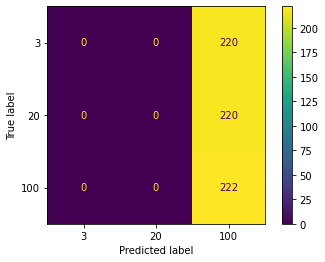

Extra trees Regression Success Rate : 99.85%


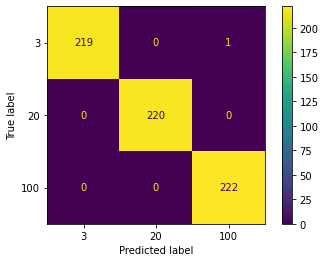

XBoost Classifier Success Rate : 99.85%


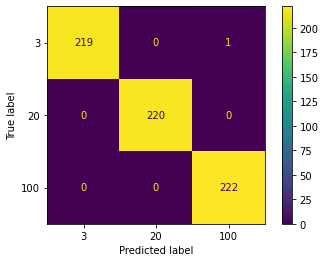

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Cooler Cond.'], test_size = 0.3, shuffle=True, stratify=y['Cooler Cond.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print('COOLER CONDITIONS')
#Dummy classfier
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for DummyClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#For XGB
model = XGBClassifier(scale_pos_weight=100)
model.fit(X_train,y_train)
y_pred_proba= model.predict_proba(X_test)
y_pred= model.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {} '.format(roc_value))
print('F1 score for XBG: {} '.format(f1_score(y_test, y_pred, average='weighted')))

#ExtratreesClassifier
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for ExtraTreesClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for ExtraTressClassifier: {} '.format(roc_value))

#Because there's an inbalance the dummy classfier predicted all target values belong to class 1, which gave a 76.52% accuracy.
#Models should be better than this.
print('COOLER CONDITIONS')
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
x_predict=model.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
x_predict=et.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
x_predict = xgb.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

VALVE CONDITIONS
F1 score for DummyClassifier: 0.3451480362537765 
Area under the ROC Curve for DummyClassifier: 0.5 
Area under the ROC Curve for XGB: 0.9904494248885131 
F1 score for XBG: 0.9156209171931806 
F1 score for ExtraTreesClassifier: 0.9802632123091393 
Area under the ROC Curve for ExtraTreesClassifier: 0.9987427704588627 
Dummy Classifier Success Rate : 51.06%


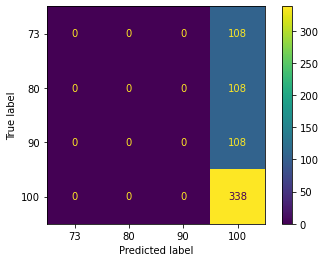

Extra trees Regression Success Rate : 98.19%


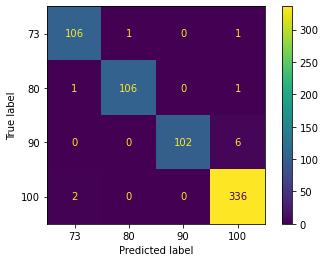

XBoost Classifier Success Rate : 91.84%


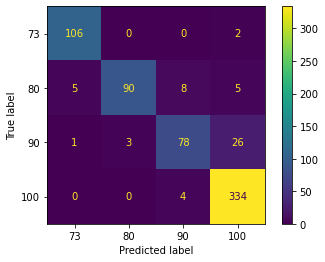

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Valve Cond.'], test_size = 0.3, shuffle=True, stratify=y['Valve Cond.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('VALVE CONDITIONS')
#Dummy classfier
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for DummyClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#For XGB
model = XGBClassifier(scale_pos_weight=100)
model.fit(X_train,y_train)
y_pred_proba= model.predict_proba(X_test)
y_pred= model.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {} '.format(roc_value))
print('F1 score for XBG: {} '.format(f1_score(y_test, y_pred, average='weighted')))

#ExtratreesClassifier
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for ExtraTreesClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for ExtraTreesClassifier: {} '.format(roc_value))

#Because there's an inbalance the dummy classfier predicted all target values belong to class 1, which gave a 76.52% accuracy.
#Models should be better than this.
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
x_predict=model.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
x_predict=et.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
x_predict = xgb.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

PUMP LEAKAGE
F1 score for DummyClassifier: 0.39367792445954364 
Area under the ROC Curve for DummyClassifier: 0.5 
Area under the ROC Curve for XGB: 0.9997290093118969 
F1 score for XBG: 0.9939462491524412 
F1 score for ExtraTreesClassifier: 0.9969853965250962 
Area under the ROC Curve for ExtraTreesClassifier: 0.999961179248535 
Dummy Classifier Success Rate : 55.29%


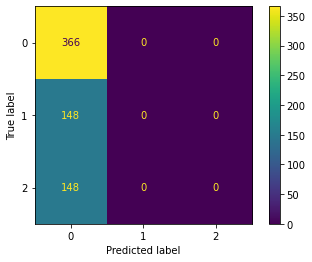

Extra trees Regression Success Rate : 99.70%


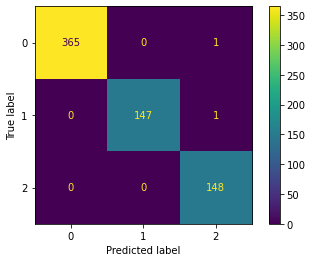

XBoost Classifier Success Rate : 99.40%


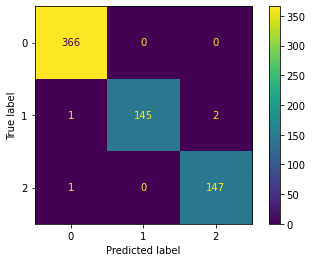

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y['pump leakage'], test_size = 0.3, shuffle=True, stratify=y['pump leakage'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('PUMP LEAKAGE')
#Dummy classfier
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for DummyClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#For XGB
model = XGBClassifier(scale_pos_weight=100)
model.fit(X_train,y_train)
y_pred_proba= model.predict_proba(X_test)
y_pred= model.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {} '.format(roc_value))
print('F1 score for XBG: {} '.format(f1_score(y_test, y_pred, average='weighted')))

#ExtratreesClassifier
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for ExtraTreesClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for ExtraTreesClassifier: {} '.format(roc_value))

#Because there's an inbalance the dummy classfier predicted all target values belong to class 1, which gave a 76.52% accuracy.
#Models should be better than this.
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
x_predict=model.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
x_predict=et.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
x_predict = xgb.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

pump leakage
F1 score for DummyClassifier: 0.39367792445954364 
Area under the ROC Curve for DummyClassifier: 0.5 
Area under the ROC Curve for XGB: 0.9997808365043899 
F1 score for XBG: 0.9894522575561338 
F1 score for ExtraTreesClassifier: 0.9924657107014141 
Area under the ROC Curve for DummyClassifier: 0.9997823158629492 
Dummy Classifier Success Rate : 55.29%


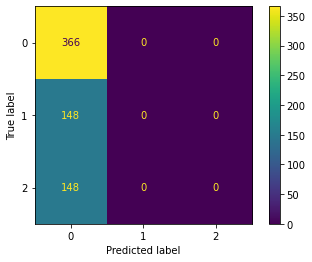

Extra trees Regression Success Rate : 99.40%


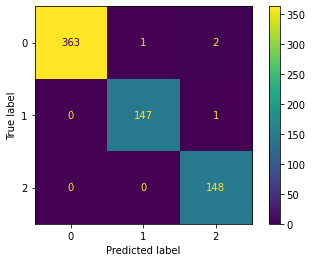

XBoost Classifier Success Rate : 98.94%


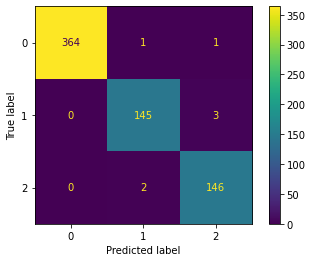

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y['pump leakage'], test_size = 0.3, shuffle=True, stratify=y['pump leakage'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('pump leakage')
#Dummy classfier
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for DummyClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#For XGB
model = XGBClassifier(scale_pos_weight=100)
model.fit(X_train,y_train)
y_pred_proba= model.predict_proba(X_test)
y_pred= model.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {} '.format(roc_value))
print('F1 score for XBG: {} '.format(f1_score(y_test, y_pred, average='weighted')))

#ExtratreesClassifier
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for ExtraTreesClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#Because there's an inbalance the dummy classfier predicted all target values belong to class 1, which gave a 76.52% accuracy.
#Models should be better than this.
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
x_predict=model.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
x_predict=et.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
x_predict = xgb.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

Hydraulic accm.
F1 score for DummyClassifier: 0.19571959468491834 
Area under the ROC Curve for DummyClassifier: 0.5 
Area under the ROC Curve for XGB: 0.9967166269773002 
F1 score for XBG: 0.959533606403011 
F1 score for ExtraTreesClassifier: 0.9909437503383328 
Area under the ROC Curve for DummyClassifier: 0.9998127405523738 
Dummy Classifier Success Rate : 36.56%


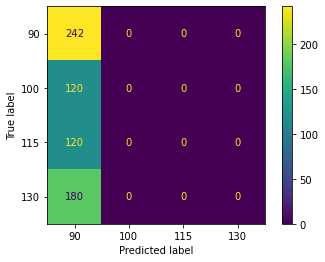

Extra trees Regression Success Rate : 99.09%


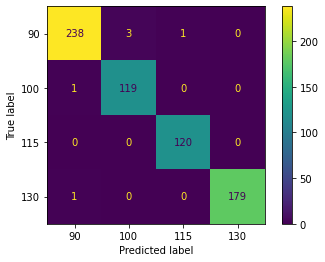

XBoost Classifier Success Rate : 95.92%


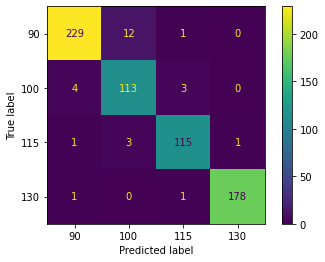

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Hydraulic accm.'], test_size = 0.3, shuffle=True, stratify=y['Hydraulic accm.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Hydraulic accm.')
#Dummy classfier
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for DummyClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#For XGB
model = XGBClassifier(scale_pos_weight=100)
model.fit(X_train,y_train)
y_pred_proba= model.predict_proba(X_test)
y_pred= model.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {} '.format(roc_value))
print('F1 score for XBG: {} '.format(f1_score(y_test, y_pred, average='weighted')))

#ExtratreesClassifier
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(X_train,y_train)
y_pred= model.predict(X_test)
print('F1 score for ExtraTreesClassifier: {} '.format(f1_score(y_test, y_pred, average='weighted')))
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
y_pred_proba =model.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for DummyClassifier: {} '.format(roc_value))

#Because there's an inbalance the dummy classfier predicted all target values belong to class 1, which gave a 76.52% accuracy.
#Models should be better than this.
model = DummyClassifier(strategy='prior')
model.fit(X_train,y_train)
x_predict=model.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
x_predict=et.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
x_predict = xgb.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()